In [972]:

!pip install --upgrade pip
!pip install torch
!pip install torchvision # using for getting mnist dataset 

import torch as tc
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision.datasets as datasets
from torch import nn


ERROR: Invalid requirement: '#'


# Classe derivada do PyTorch

In [973]:
class TorchModel(nn.Module):
	def __init__(self,dimensions=(2,2,2,2), activation="sigmoid", output_activation="sigmoid"):
		super(TorchModel, self).__init__()

		# Change this to CUDA
		self.device 		= "cuda" if tc.cuda.is_available() else "cpu"
		self.loss 			= nn.MSELoss()
		self.optmizer 		= None
		self.losses 		= list()
		self.epoch_losses = list()
		self.accuracies 	= list()

		self = self.to(self.device)
		
		print(f"> Rodando tudo em {self.device}")
		
		#// TODO(Everton): Implement choice of activations
		if activation == "sigmoid":
			pass
		
		"""# // TODO(Everton): Implement change of dimensions
		self.layers = nn.Sequential(
			nn.Linear(784,128), 	# 1 layer:-> 784 input 128 o/p
			nn.ReLU(),          	# Defining Regular linear unit as activation
			nn.Linear(128,64),  	# 2 Layer:-> 128 Input and 64 O/p
			# Possivel estabelecer um droupout -> nn.Dropout(p = 0.4),
			nn.ReLU(),          	# Defining Regular linear unit as activation
			nn.Linear(64,10),   	# 3 Layer:-> 64 Input and 10 O/P as (0-9)
			nn.Sigmoid() # Defining the log softmax to find the probablities for the last output unit
      )"""
		layers = list()
		
		# Setting Interim Layers
		if activation.lower() == "relu":
			for idx in range(len(dimensions)-2):
				layers.append(nn.Linear(dimensions[idx],dimensions[idx + 1]))
				layers.append(nn.ReLU())

		elif activation.lower()  == "sigmoid":
			for idx in range(len(dimensions)-2):
				layers.append(nn.Linear(dimensions[idx],dimensions[idx + 1]))
				layers.append(nn.Sigmoid())

		elif activation.lower()  == "tanh":
			for idx in range(len(dimensions)-2):
				layers.append(nn.Linear(dimensions[idx],dimensions[idx + 1]))
				layers.append(nn.Tanh())
			
				

		# Setting output Layer
		layers.append(nn.Linear(dimensions[-2],dimensions[-1]))
		if output_activation.lower() == "sigmoid":
			layers.append(nn.Sigmoid())

		if output_activation.lower() == "softmax":
			layers.append(nn.Softmax())

		if output_activation.lower() == "relu":
			layers.append(nn.ReLU())

		# Unpack Layers
		self.layers = nn.Sequential(*layers)

	def forward(self, X):
		return self.layers(X)

	def fit(self, inputs, outputs,shuffle=True, autosave=False, epochs:int=10, lr=0.036):

		self.optmizer = tc.optim.SGD(self.parameters(), lr=lr)

		for e in range(epochs):
			if autosave:
				# Save each 20th epoch
				if e % 20 == 0:
					self.save(f"Model{e/20}")
					print(f"> epoch:{len(self.epoch_losses)+1}th, auto saved in : " + f"Model{e/20}")
			
			# A cada epoch calculo a media do erro de cada set de treinamento

			train_loss = self.__train(inputs,outputs, lr, shuffle=shuffle)
			self.epoch_losses.append(train_loss)
			self.losses = list()

			#self.losses.append(train_loss)

			if e % 1 == 0:
				print(f"Epoch: {len(self.epoch_losses)}th; Train Loss: {train_loss}; Acurracy: {self.accuracies[-1]}")

	
	def __train(self, inputs, outputs, lr, shuffle=True):	
		self.train()

		# __train corresponde a 1 epoch, sendo assim é o erro acumulado do epoch inteiro
		cumloss = 0.0
		itr_count = 0 
		
		# A cada epoch calculo a media do erro de cada set de treinamento
		predicts = list()
		
		if shuffle:
			assert len(inputs) == len(outputs)
			p = np.random.permutation(len(inputs))
			inputs,outputs = inputs[p], outputs[p]

		for index in range(len(inputs)):
			x = inputs[index]
			y = outputs[index]


			if tc.is_tensor(x):
				x = x.to(self.device)
			else:
				x = tc.tensor(x).to(self.device)
				
			x = x.type(tc.float32)
			
			if tc.is_tensor(y):
				y = y.to(self.device)
			else:
				y = tc.tensor(y).to(self.device)
			
			y = y.type(tc.float32)
			##type(X)
			# y = y.unsqueeze(784).float().to(device)		

			# Note that nn.Module objects are used as if they are functions 
			#(i.e they are callable), but behind the scenes 
			# Pytorch will call our forward method automatically.
			pred = self.__call__(x)
			loss = nn.MSELoss()(pred, y)

			#prediction = np.array([(guess == y_predict.max()).astype(int) for guess in y_predict]);
			prediction = (pred == pred.max()).type(tc.int)
			predicts.append(prediction)

			# loss = tc.criterion(X, y)		
			# zera os gradientes acumulados
			self.optmizer.zero_grad()
			# computa os gradientes
			loss .backward()
			# anda, de fato, na direção que reduz o erro local
			self.optmizer.step()		
			# loss é um tensor; item pra obter o float

			single_loss = loss.item()

			self.losses.append(single_loss)

			cumloss += single_loss
			itr_count += 1
		# retornamos o erro acumulado dividico pela quantidade de dados
		# mas antes adicionamos acurácia
		self.accuracies.append(self.accuracy(predicts, outputs)[0])
		return cumloss / len(inputs)
		
	def test(self, inputs, outputs):
		self.eval()
		print("> Entrou no Modo Teste")
		predicts = list()
		
		total 	= len(inputs)
		correct = 0 
		with tc.no_grad():
			
			for i in range(total):
				x = inputs[i]
				y = outputs[i]
				
				if tc.is_tensor(x):
					x = x.to(self.device)
				else:
					x = tc.tensor(x).to(self.device)
					
				x = x.type(tc.float32)
				
				if tc.is_tensor(y):
					y = y.to(self.device)
				else:
					y = tc.tensor(y).to(self.device)
				
				y = y.type(tc.float32)
				
				pred = self.__call__(x)


				prediction = (pred == pred.max()).type(tc.int)
				predicts.append(prediction)
				pred_index  = prediction.argmax()

				groud_truth_index = y.argmax()
				
				if (pred_index == groud_truth_index):
					correct += 1
		print(f"Accuracy of the network on the {total} test images: %d %%" % (100 * correct / total))	
		print(self.accuracy(predicts,outputs)[0])	
		
		return (100 * correct / total)

	def predict(self, x):
			
		self.eval()
		print("> Entrou no Modo Predicao")		
		with tc.no_grad():
			if tc.is_tensor(x):
				x = x.to(self.device)
			else:
				x = tc.tensor(x).to(self.device)	
			x = x.type(tc.float32)
			pred = self.__call__(x)
		return pred
		# they must be the same legnth

	# outputs must be hot encoded
	def accuracy(self,predictions,outputs):
		right_guesses = 0 
		total = len(predictions)
		wrong_indexes = list()

		for index, guess in enumerate(predictions):
			if np.array_equal(guess,outputs[index]):
				right_guesses += 1
			else:
				wrong_indexes.append(index)
		if(total > 0):
			return (right_guesses/total,wrong_indexes)
	
	def print(self):
		print(f"\nCurrent Loss: {self.epoch_losses[-1]}")
		print(f"\nCurrent Acurácia: {self.accuracies[-1]}\n")
		plt.title("Erro Médio por Epochs")
		plt.xlabel("Epochs")
		plt.ylabel("Loss")
		plt.plot(tc.arange(len(self.epoch_losses)), self.epoch_losses, color= "b", linestyle = "-", linewidth=1.25)		
		plt.plot(self.epoch_losses)
	

## Função para testar modelo

In [974]:
def test_prediction(index, data, model:nn.Module):
	current_image = data["inputs"][index]

	y_predict = model.predict(data["inputs"][index])
	
	prediction = (y_predict == y_predict.max()).type(tc.int)

	guess = list(prediction).index(1)
	
	label = data["outputs"][index]
	ground_truth = list(label).index(1)

	print("Label: ", label)
	print("Prediction: ", prediction)

	plt.gray()
	plt.title("Model thinks it is: " + str(guess) + "\nGround truth: " + str(ground_truth))
	plt.imshow( current_image.reshape((28, 28)) * 255, interpolation='nearest')
	plt.xticks([])
	plt.yticks([0])
	plt.show()

# Pegando e transformando os dados MNIST

In [975]:

# Se transformarmos para algo ao invez de 'None' o que acontece?
train_data 	= datasets.MNIST(root='./data', train=True, download=True, transform=None)
test_data 	= datasets.MNIST(root='./data', train=False, download=True, transform=None)

# Printando um exemplo para ver do que se trata
print(train_data[1][0])
print(train_data[0][1])

train_data = {
	"inputs"	: tc.tensor([np.array(x[0], np.float32, copy=False).reshape(28*28)/255.0 for x in train_data]),
	"outputs": tc.tensor([[y[1] == x for x in range(10)] for y in train_data]).type(tc.int32)
}

test_data = {
	"inputs"	: tc.tensor([np.array(x[0], np.float32, copy=False).reshape(28*28)/255.0 for x in test_data]),
	"outputs": tc.tensor([[y[1] == x for x in range(10)] for y in test_data]).type(tc.int32)
}

all_data = {
		"inputs"	: tc.cat( (train_data["inputs" ], test_data["inputs"] )	,0),
		"outputs": tc.cat( (train_data["outputs"], test_data["outputs"])	,0)
}

<PIL.Image.Image image mode=L size=28x28 at 0x1D039038E80>
5


In [976]:
# Path to save and load Model
path = "./models/" + "torch_model.pt"

# Model class must be defined somewhere

model = tc.load(path); model.eval()
""" Se quiser treinar do inicio, descomente a proxima linha"""

"""
model = TorchModel(
	dimensions=(784,256,256,10),
	activation="relu" ,
	output_activation="softmax"
)
"""

'\nmodel = TorchModel(\n\tdimensions=(784,256,256,10),\n\tactivation="relu" ,\n\toutput_activation="softmax"\n)\n'

## Treinamento do Modelo (learning rate, epochs)

In [977]:

epochs = 1
lr = 0.015
model.fit(
	train_data["inputs"],
	train_data["outputs"], 
	epochs=epochs, 
	lr=lr
)

C:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 15th; Train Loss: 0.0007156065857851267; Acurracy: 0.9964


## Salvando modelo e printando Losses/Epochs

In [978]:
## -> Save onde Parameter tc.save(model.state_dict(), path)
## -> Save onde Whole Model: 
tc.save(model, path)


Current Loss: 0.0007156065857851267

Current Acurácia: 0.9964



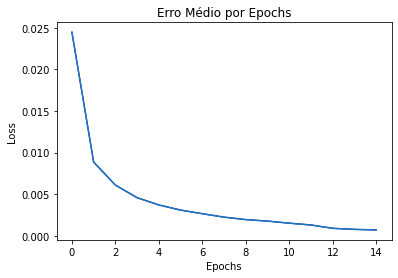

In [979]:
model.print()


## Testando modelo com 10K imagens

In [980]:
model.test(test_data["inputs"],test_data["outputs"])

> Entrou no Modo Teste


C:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Accuracy of the network on the 10000 test images: 98 %
0.9822


98.22

## Teste do modelo com **test_data**

> Entrou no Modo Predicao
Label:  tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0], dtype=torch.int32)
Prediction:  tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0], dtype=torch.int32)


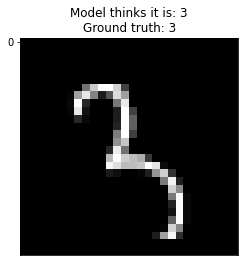

In [981]:
index = 196-1
test_prediction(index, data=test_data,model=model)	

## Redução de Dimensões usando PCA, como tecnica
### Para todos os cálculos, foi-se utilizado tensors de Pytorch

In [982]:
class TorchPCA:
	def __init__(self,data):
		self.X = tc.tensor(data)
		
		self.mean = tc.ones(1)
		self.cov = tc.ones(1)

		self.evalues = tc.ones(1)
		self.evectors = tc.ones(1)
		
		self.__normalize()
		self.__decompose()
		
	def __normalize(self):
		# Mean centering
		self.mean = tc.mean(self.X, axis=0)
		self.std_dev = tc.std(self.X, axis=0)
		print(f"{self.std_dev.shape=}")
		self.X = (self.X - self.mean)#*(np.ones(self.std_dev.shape)/self.std_dev)
		
		print(f"{self.mean.shape=}")

		# covariance, function needs samples as columns
		# cov = np.cov(X.T)
		self.cov = tc.cov(X.T)
		print(f"{self.cov.shape=}")
		return self.X
		
	
	def __decompose(self):
		evalues, evectors = tc.linalg.eig(self.cov)
		evectors = evectors.T.real
		evalues = evalues.real
		print(f"{evalues.shape=}")
		print(f"{evectors.shape=}")
		# -> eigenvector v = [:,i] column vector, transpose for easier calculations
		# sort eigenvectors
		indexes = tc.argsort(evalues, dim=- 1, descending=True) 
		# Gotta sort these array in consonance
		evalues = evalues[indexes]
		evectors = evectors[indexes]
		
		self.evalues  = evalues
		self.evectors = evectors
		return evalues, evectors

	def change_basis(self,data, num_components:int):
		self.num_components = num_components
		# project data
		# X = X - self.mean
		X_transformed = self.X @ self.evectors[0 : num_components].T
		return X_transformed

	def invert_basis(self, data_transformed):

		X_reconstructed = (self.evectors[0 : self.num_components].T @ data_transformed.T).T
		print(f"{X_reconstructed.shape=}")
		return X_reconstructed



## Função para auxiliar na vizualização de Matrizes de Covariancia

In [983]:
def plot_matrix(matrix:np.ndarray, dim=(28,28),figsize=(6,6)):
	plt.figure(figsize=figsize)
	plt.gray()
	#plt.imshow( example.reshape((28, 28)),cmap='binary_r', interpolation='nearest',clim=(-50, 255))
	plt.imshow(matrix.reshape(dim),interpolation="none")
	plt.xticks([])
	plt.yticks([])
	plt.show()

## Observe a Covariancia de X original

### Podemos ver visualmente que é *Simétrica* e que na diagmosal é mais positiva que cada dimensão $pixel_i$ existe alta correlação com outros eixos $pixel_m$ {$n,m = 1,2...784$}

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_14216/3601007384.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = tc.tensor(all_data["inputs"])


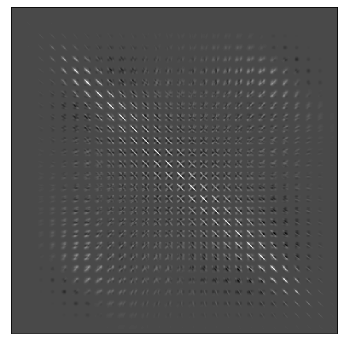

In [984]:
X = tc.tensor(all_data["inputs"])
plot_matrix(tc.cov(X.T),dim=(784,784))


C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_14216/1483385437.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = tc.tensor(data)


self.std_dev.shape=torch.Size([784])
self.mean.shape=torch.Size([784])
self.cov.shape=torch.Size([784, 784])
evalues.shape=torch.Size([784])
evectors.shape=torch.Size([784, 784])


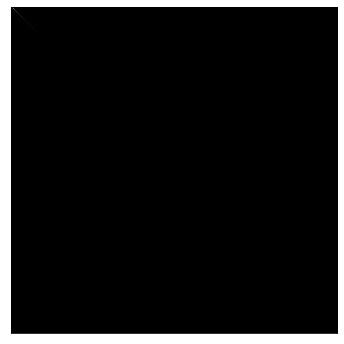

Shape de X: torch.Size([70000, 784])
Shape de X_transformed: torch.Size([70000, 784])


' Note que praticamente não da pra ver a parte branca que representa a variância na diagonal da matriz de covariância'

In [985]:

# Project the data onto the 2 primary principal components
pca = TorchPCA(X)

X_transformed = pca.change_basis(X,num_components= 784)

plot_matrix(np.cov(X_transformed.T),dim=(784,784))

print("Shape de X:", X.shape)
print("Shape de X_transformed:", X_transformed.shape)
""" Note que praticamente não da pra ver a parte branca que representa a variância na diagonal da matriz de covariância"""


## Com **50** Componentes principais:
### podemos observa a Matriz Cov dos dados transformados e percebendo que toda da variancia é concentrada na diagonal e 82% nos primeiros 50 autovetores

### Podemos observar o valor acumulativo quantidade de informação dos componentes principais no plot acumulativo das autovalores abaixo:
### Basicamente é a visualização de $COV_{\hat{X}}$ que é $\Lambda$ de $X^T\cdot X$ original

Variancia correponde há 50 PC's: tensor(0.8286)
Shape do novo X_transformed: torch.Size([70000, 50])


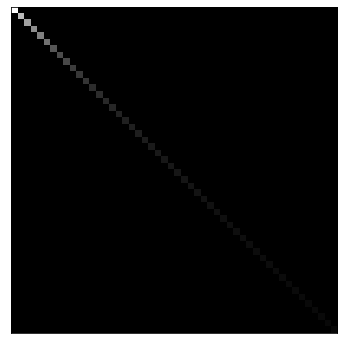

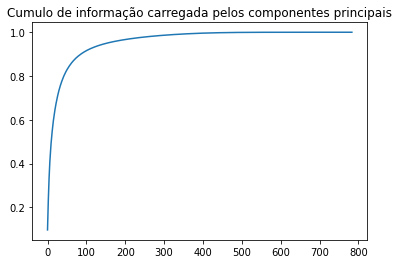

In [986]:
componentes_qntd = 50
print(f"Variancia correponde há {componentes_qntd} PC's:", tc.cumsum(pca.evalues,dim=0)[componentes_qntd]/tc.sum(pca.evalues))

X_transformed = pca.change_basis(X,num_components=componentes_qntd)

print("Shape do novo X_transformed:", X_transformed.shape)
plot_matrix(np.cov(X_transformed.T),dim=(componentes_qntd,componentes_qntd))

# Com 50 PC's temos 82% e com 784 assintota 100% de informação, como é esperado
plt.title("Cumulo de informação carregada pelos componentes principais")
plt.plot(tc.cumsum(pca.evalues,dim=0)/tc.sum(pca.evalues))


### A reconstrução de $\hat{X}$ a partir de *50 PC's* mantém bem parecida a distribuição de covariação da matriz de covariancia inicial ($COV_{X}$) 

X_reconstructed.shape=torch.Size([70000, 784])


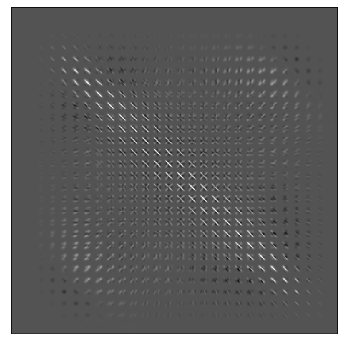

Shape of X_reconstructed: torch.Size([70000, 784])


In [987]:
X_reconstructed = pca.invert_basis(X_transformed)

plot_matrix(np.cov(X_reconstructed.T),dim=(784,784))
print("Shape of X_reconstructed:", X_reconstructed.shape)

## Usando os 3 melhores componentes princiapis
#### Projetamos os dados nele

Variancia correponde há 2 PC's: tensor(0.2305)
pc1.shape=torch.Size([70000])
pc2.shape=torch.Size([70000])
colors.shape=(70000,)


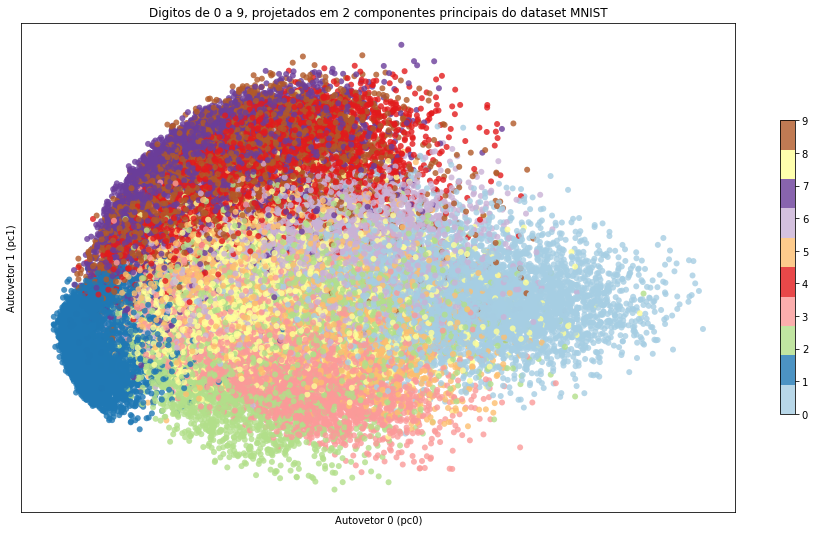

In [988]:
pcs_indices = [0,1,2]
#pcs_indices = [48,49,2]

print(f"Variancia correponde há {2} PC's:", tc.cumsum(pca.evalues, dim=0)[2]/tc.sum(pca.evalues))

pc1 = X_transformed[:, pcs_indices[0]]
pc2 = X_transformed[:, pcs_indices[1]]
pc3 = X_transformed[:, pcs_indices[2]]

colors = np.array([list(y).index(1) for y  in all_data["outputs"]])

print(f"{pc1.shape=}")
print(f"{pc2.shape=}")
print(f"{colors.shape=}")


plt.figure(figsize=(16,9))

plt.scatter(
   	pc1, pc2, c=colors, edgecolor="none", alpha=0.8, 
		#cmap=plt.cm.get_cmap("RdGy_r", 10)
		#cmap=plt.cm.get_cmap("rainbow", 10)
		cmap=plt.cm.get_cmap("Paired", 10)
	)
plt.xticks([])
plt.yticks([])
plt.xlabel(f"Autovetor {pcs_indices[0]} (pc{pcs_indices[0]})")
plt.ylabel(f"Autovetor {pcs_indices[1]} (pc{pcs_indices[1]})")
plt.title("Digitos de 0 a 9, projetados em 2 componentes principais do dataset MNIST")
plt.colorbar(shrink = 0.6)
plt.show()



Variancia correponde há 3 PC's: tensor(0.2845)


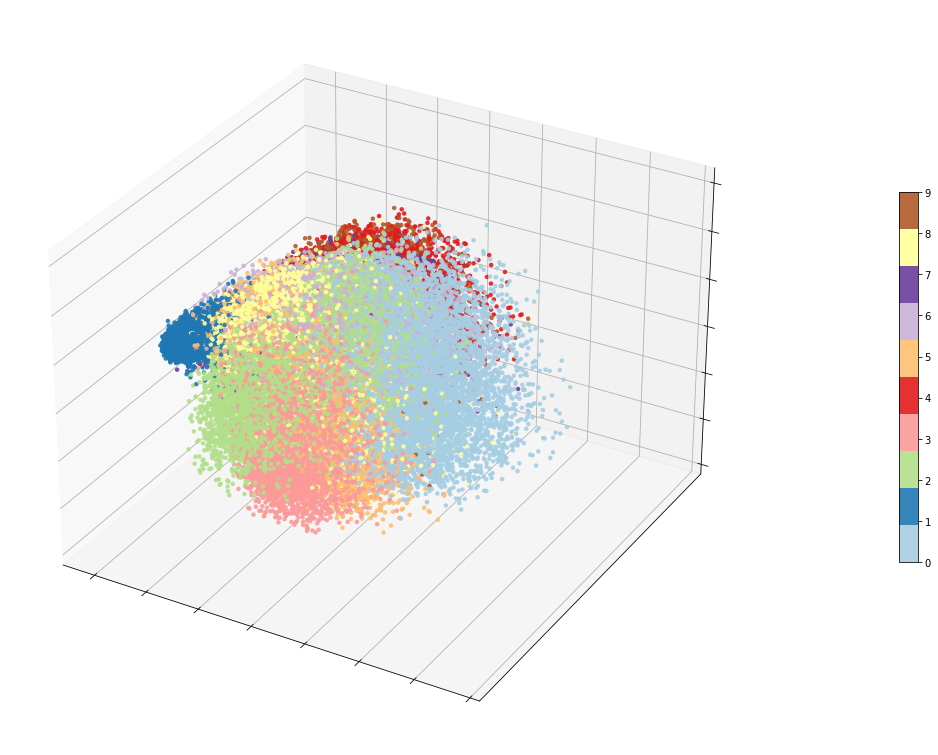

In [989]:
print(f"Variancia correponde há {3} PC's:", tc.cumsum(pca.evalues, dim=0 )[3]/tc.sum(pca.evalues))

# Create the figure
fig = plt.figure(figsize=(54,30))
ax = fig.add_subplot(211,projection='3d')

# Plot the values
scatterplot = ax.scatter(
   	pc1, pc2, pc3, c=colors, edgecolor="none", alpha=0.9, 
		cmap=plt.cm.get_cmap("Paired", 10)
		#cmap=plt.cm.rainbow
		#cmap=plt.cm.RdGy_r
	)
#ax.set_xlabel('X-axis')
#ax.set_ylabel('Y-axis')
#ax.set_zlabel('Z-axis')
fig.colorbar(scatterplot,shrink = 0.5)
ax.yaxis.set_major_locator(plt.NullLocator())
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.zaxis.set_major_formatter(plt.NullFormatter())
plt.show()

## Usando os piores componentes princiapis
#### Projetamos os dados nele, perceba que há menos dispersão.
#### Ou seja, mais dificil de achar clusters

Variancia correponde há 2 PC's: tensor(0.2305)
pc1.shape=torch.Size([70000])
pc2.shape=torch.Size([70000])
colors.shape=(70000,)


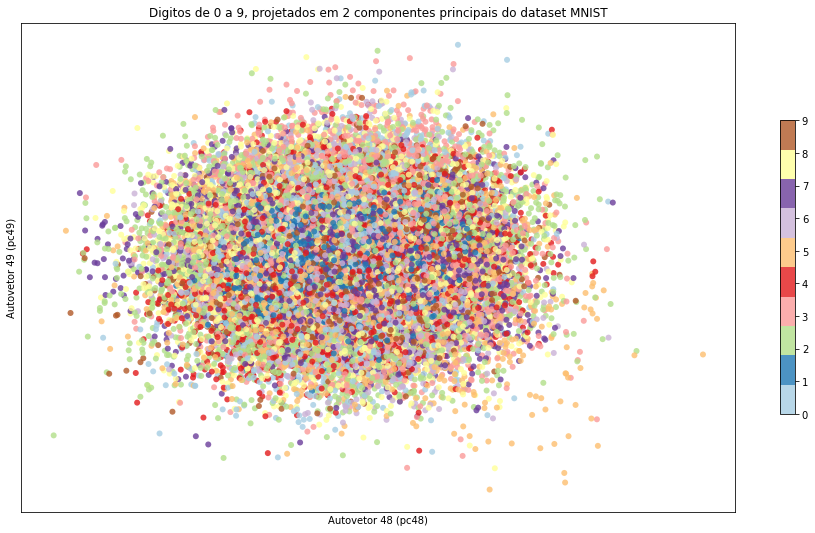

In [990]:
pcs_indices = [48,49,2]

print(f"Variancia correponde há {2} PC's:", tc.cumsum(pca.evalues, dim=0)[2]/tc.sum(pca.evalues))

pc1 = X_transformed[:, pcs_indices[0]]
pc2 = X_transformed[:, pcs_indices[1]]
pc3 = X_transformed[:, pcs_indices[2]]

colors = np.array([list(y).index(1) for y  in all_data["outputs"]])

print(f"{pc1.shape=}")
print(f"{pc2.shape=}")
print(f"{colors.shape=}")


plt.figure(figsize=(16,9))

plt.scatter(
   	pc1, pc2, c=colors, edgecolor="none", alpha=0.8, 
		#cmap=plt.cm.get_cmap("RdGy_r", 10)
		#cmap=plt.cm.get_cmap("rainbow", 10)
		cmap=plt.cm.get_cmap("Paired", 10)
	)
plt.xticks([])
plt.yticks([])
plt.xlabel(f"Autovetor {pcs_indices[0]} (pc{pcs_indices[0]})")
plt.ylabel(f"Autovetor {pcs_indices[1]} (pc{pcs_indices[1]})")
plt.title("Digitos de 0 a 9, projetados em 2 componentes principais do dataset MNIST")
plt.colorbar(shrink = 0.6)
plt.show()



Variancia correponde há 3 PC's: tensor(0.2845)


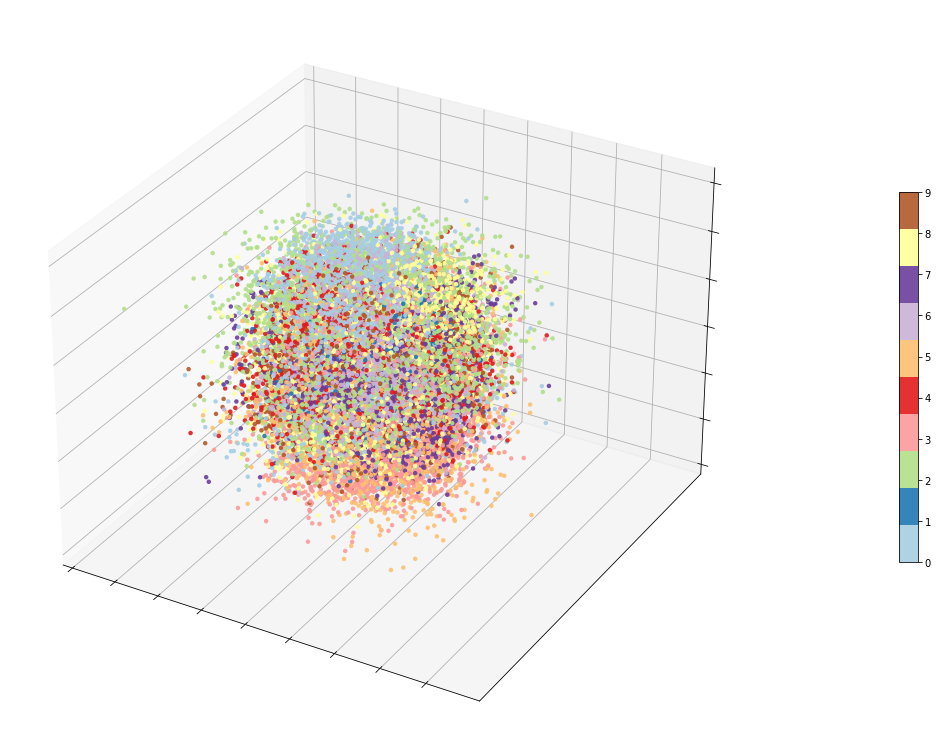

In [991]:
print(f"Variancia correponde há {3} PC's:", tc.cumsum(pca.evalues, dim=0 )[3]/tc.sum(pca.evalues))

# Create the figure
fig = plt.figure(figsize=(54,30))
ax = fig.add_subplot(211,projection='3d')

# Plot the values
scatterplot = ax.scatter(
   	pc1, pc2, pc3, c=colors, edgecolor="none", alpha=0.9, 
		cmap=plt.cm.get_cmap("Paired", 10)
		#cmap=plt.cm.rainbow
		#cmap=plt.cm.RdGy_r
	)
#ax.set_xlabel('X-axis')
#ax.set_ylabel('Y-axis')
#ax.set_zlabel('Z-axis')
fig.colorbar(scatterplot,shrink = 0.5)
ax.yaxis.set_major_locator(plt.NullLocator())
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.zaxis.set_major_formatter(plt.NullFormatter())
plt.show()

## Reconstrução do Digito
### Podemos também observar visualmente quanto de informação é possivel recuperar de acordo com a quantidade de número de componentes principais (PC's) que escolhermos
#### TROQUE **componentes_qntd** para manter mais ou menos informação
#### TROQUE **indices_digito** para mudar o digito mostrado

Note: Se deixar componentes_qntd abaixo de **4**, quase TODO numero parece um zero, pois deve ser as coisas mais comum entre um e outro


#### $\implies$ Mude componentes_qntd para **4**

X_reconstructed.shape=torch.Size([70000, 784])


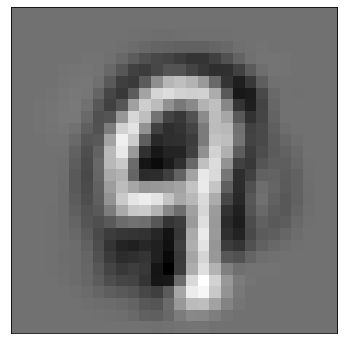

In [992]:
""" Troque a qntd de componentes e veja a reconstrução """
# PC's no intervalo [1,784]
componentes_qntd = 50
# Indices no intervalo [0,70'000)
indices_digito = 350



X_transformed 		= pca.change_basis(X,num_components=componentes_qntd)
X_reconstructed 	= pca.invert_basis(X_transformed)
plot_matrix(X_reconstructed[indices_digito].reshape(28,28))

## Reconstrução com com 4 componentes principais
### Quase todos os número parecem zero

X_reconstructed.shape=torch.Size([70000, 784])


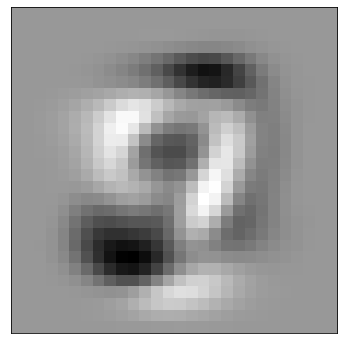

In [993]:
componentes_qntd = 4
X_transformed 		= pca.change_basis(X,num_components=componentes_qntd)
X_reconstructed 	= pca.invert_basis(X_transformed)
plot_matrix(X_reconstructed[indices_digito].reshape(28,28))

# Treinamento
## Agora partimos para o treinamento do modelo com dimensão reduzida
Vamos procurar PC's que nos deem aproximadamente 95%  da informação retida.

In [994]:
# Vamos escolher um power
n_components_trainning = 200
split = 60000

pca_train = TorchPCA(all_data["inputs"])
reduced_data = pca_train.change_basis(all_data["inputs"],n_components_trainning)

normalize_term = tc.amax(reduced_data)

print("Normalizing Term:",	normalize_term)
print(f"Variancia correponde há {n_components_trainning} PC's:", tc.cumsum(pca.evalues,dim=0)[n_components_trainning-1]/tc.sum(pca.evalues))

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_14216/1483385437.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = tc.tensor(data)


self.std_dev.shape=torch.Size([784])
self.mean.shape=torch.Size([784])
self.cov.shape=torch.Size([784, 784])
evalues.shape=torch.Size([784])
evectors.shape=torch.Size([784, 784])
Normalizing Term: tensor(9.3490)
Variancia correponde há 200 PC's: tensor(0.9665)


In [995]:

# Treinamos com 60 mil exemplos
train_data = {
	"inputs" :	reduced_data[:split]/normalize_term,
	"outputs":	all_data["outputs"][:split]
}

# Restante dos 10 mil exemplos que o modelo não viu, será nossos dados de teste
test_data = {
	"inputs" :	reduced_data[split:]/normalize_term,
	"outputs":	all_data["outputs"][split:]
}

print(F"{train_data['inputs'].shape=}")
print(F"{train_data['outputs'].shape=}")
print(f"Std Dev : {tc.std(train_data['inputs'][0])=}")

print(F"{test_data['inputs'].shape=}")
print(F"{test_data['outputs'].shape=}")

train_data['inputs'].shape=torch.Size([60000, 200])
train_data['outputs'].shape=torch.Size([60000, 10])
Std Dev : tc.std(train_data['inputs'][0])=tensor(0.0519)
test_data['inputs'].shape=torch.Size([10000, 200])
test_data['outputs'].shape=torch.Size([10000, 10])


## Treinando Modelo

- 200 dimensões input
- 3 hidden_layers de 256 dimensões
- 0.025 lr

In [996]:
# Modelo com configurações mencionada anteriormente

pca_path = "./models/" + "torch_pca_model.pt"

#pca_model = TorchModel(dimensions=(n_components_trainning,256,256,256,10), activation="relu", output_activation="sigmoid")
"""Caso queira começar do zero, comente a proxima linha e descomente a linha anterior"""
pca_model  = tc.load(pca_path);pca_model.eval()

print(train_data["inputs"].shape)
print(train_data["outputs"].shape)


torch.Size([60000, 200])
torch.Size([60000, 10])


In [997]:
"""É possivel repetir essa celula diversas vezes para treinar o modelo, com epochs, our learning rate diferentes"""
learning_rate = 0.015

epochs = 1

print("\n> Model Started Training...\n")
			
pca_model.fit(
	train_data["inputs"],
	train_data["outputs"],
	lr = learning_rate, 
	epochs=epochs,
)
	
print("> Done.")




> Model Started Training...

Epoch: 26th; Train Loss: 0.0017006106334709191; Acurracy: 0.9904833333333334
> Done.



Current Loss: 0.0017006106334709191

Current Acurácia: 0.9904833333333334



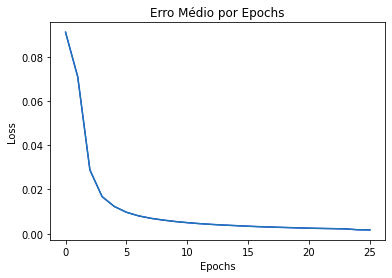

In [998]:
""" Seeing Stats And Saving Model"""

pca_model.print()

#pca_model.save("./models/" + model_filename)
#model.save("test_model",compact=True)

In [999]:
tc.save(pca_model, pca_path)

### Testando Modelo PCA


In [1000]:
#pca_model.fit( test_data["inputs"],test_data["outputs"],lr = learning_rate, epochs=1)
pca_model.test(test_data["inputs"],test_data["outputs"])
	

> Entrou no Modo Teste
Accuracy of the network on the 10000 test images: 97 %
0.9772


97.72

#### Função p/ testar a acurácia dos restante 10 mil digitos que o modelo não viu ainda
##### e ainda retorna todos os indices errados

### Escolha um index no intervalo [0,10'000)
#### *A ideia é poder ver a imagem e a predição do modelo*

In [1001]:
# Escolha um index no intervalo [0,10'000) Cerca de 98% vai estar certo
test_data_reconstructed = {
	"inputs": pca_train.invert_basis(test_data["inputs"]),
	"outputs": test_data["outputs"]
} 



X_reconstructed.shape=torch.Size([10000, 784])


> Entrou no Modo Predicao
Label:  tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=torch.int32)
Prediction:  tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=torch.int32)


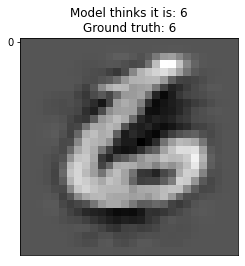

Reconstuido


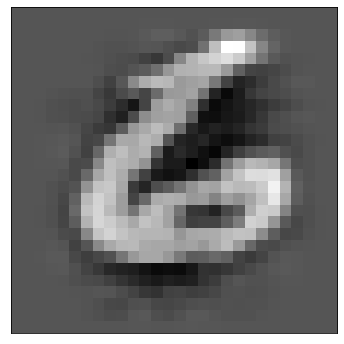

Original


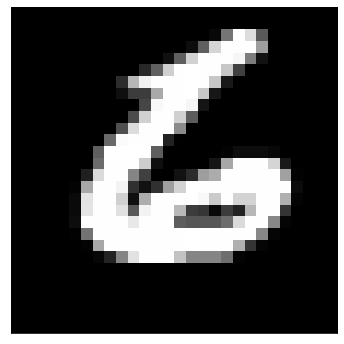

In [1003]:
index = 10000 -1

test_prediction(index,test_data_reconstructed,model)
print("Reconstuido")

plot_matrix(test_data_reconstructed["inputs"][index])

print("Original")
plot_matrix(all_data["inputs"][split:][index])